 # Trabajo Final - Francisco Colella - QUANt UCEMA
 
Paquetes

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import os
import math
import statsmodels.api as sm
from statsmodels.tsa.api import VAR
from statsmodels.tsa.ar_model import AR
from scipy.optimize import curve_fit
from scipy.interpolate import interp1d
from sklearn.metrics import mean_squared_error
import warnings
warnings.filterwarnings("ignore")

In [2]:
save_figs = False #If True, will overwrite the plots for the document.

Funciones

In [3]:
# formas funcionales de los modelos . El modelo de Bjork y Christensen de cuatro factores no se presenta en el trabajo.

def ns_formula(T,b1,b2,b3,lambda_NS):
    return  b1 + b2 * ((1-np.exp(-lambda_NS*T))/(lambda_NS*T)) + b3 * (((1-np.exp(-lambda_NS*T))/(lambda_NS*T)) - np.exp(-lambda_NS*T))

def twofactors_formula(T,b1,b2,lambda_NS):
    return  b1 + b2 * ((1-np.exp(-lambda_NS*T))/(lambda_NS*T))

def fourfactors_formula(T,b1,b2,b3,b4,lambda_NS):
    return  b1 + b2 * ((1-np.exp(-lambda_NS*T))/(lambda_NS*T)) + b3 * (((1-np.exp(-lambda_NS*T))/(lambda_NS*T)) - np.exp(-lambda_NS*T)) + b4 * ((1-np.exp(-2*lambda_NS*T))/(2*lambda_NS*T))

def sv_formula(T,b1,b2,b3,b4,lambda_NS,lambda_SV):
    return  b1 + b2 * ((1-np.exp(-lambda_NS*T))/(lambda_NS*T)) + b3 * (((1-np.exp(-lambda_NS*T))/(lambda_NS*T)) - np.exp(-lambda_NS*T)) + b4 * (((1-np.exp(-lambda_SV*T))/(lambda_SV*T)) - np.exp(-lambda_SV*T))
    

def yield_curve_plot_day(day,last_maturity,save_name):
    
    '''
    Función que grafica la yield curve actual para las maturities disponibles sumado a la predicted yield curve por cada modelo.
    Toma como inputs el día que se quiere graficar y la madurez mas larga disponible.
    '''
    
    #retrive betas from ols reg - Nelson Siegel model
    beta1_ols = betas_ols.beta_1[betas_ols.index==day]
    beta2_ols = betas_ols.beta_2[betas_ols.index==day]
    beta3_ols = betas_ols.beta_3[betas_ols.index==day]
    
    #retrive betas from ols reg - 2 factor model
    beta1_ols_2f= betas_ols_2f.beta_1[betas_ols_2f.index==day]
    beta2_ols_2f = betas_ols_2f.beta_2[betas_ols_2f.index==day]
    
    #four factor
    beta1_ols_4f= betas_ols_4f.beta_1[betas_ols_4f.index==day]
    beta2_ols_4f = betas_ols_4f.beta_2[betas_ols_4f.index==day]
    beta3_ols_4f = betas_ols_4f.beta_3[betas_ols_4f.index==day]
    beta4_ols_4f = betas_ols_4f.beta_4[betas_ols_4f.index==day]
    
    #Svensonn model
    beta1_ols_4fs= betas_ols_4fs.beta_1[betas_ols_4fs.index==day]
    beta2_ols_4fs = betas_ols_4fs.beta_2[betas_ols_4fs.index==day]
    beta3_ols_4fs = betas_ols_4fs.beta_3[betas_ols_4fs.index==day]
    beta4_ols_4fs = betas_ols_4fs.beta_4[betas_ols_4fs.index==day]
    
    
    #Generate model predicetd values 
    T = np.linspace(1, last_maturity, num=1001, endpoint=True)
    ns_plot = [ns_formula(t,beta1_ols,beta2_ols,beta3_ols,lambda_DL) for t in T]
    twofactors_plot = [twofactors_formula(t,beta1_ols_2f,beta2_ols_2f,lambda_DL) for t in T]
    fourfactors_plot = [fourfactors_formula(t,beta1_ols_4f,beta2_ols_4f,beta3_ols_4f,beta4_ols_4f,lambda_DL) for t in T]
    sv_plot = [sv_formula(t,beta1_ols_4fs,beta2_ols_4fs,beta3_ols_4fs,beta4_ols_4fs,lambda_DL,lambda_SV) for t in T]
    
    #plot
    plt.figure(figsize=(8,4))
    plt.plot(np.array(maturity_months),np.array(df[df.index==day]).reshape(len(maturity_months),1),'o',label='Actual')
    plt.plot(T,twofactors_plot,label='Dos factores')
    plt.plot(T,ns_plot,label = 'Nelson Siegel')
    #plt.plot(T,fourfactors_plot,label='Four Factors')
    plt.plot(T,sv_plot,label = 'Svennson')
    #plt.title(f'Yield Curve on {day.year}-{day.month}-{day.day}')
    plt.xlabel('Madurez (Meses)')
    plt.ylabel('Retornos')
    plt.legend()
    if save_figs==True:
        plt.savefig(f'{path_figs}/{save_name}.eps',bbox_inches='tight',format='eps',dpi=1000)
    plt.show()
    
    
    
    
def yield_curve_plot_day_oos(day,last_maturity):
    
    '''
    Función que grafica la yield curve actual para las maturities disponibles sumado a la predicted yield curve por cada modelo
    para predicciones fuera de la muestra de entrenamiento.
    Toma como inputs el día que se quiere graficar y la madurez mas larga disponible.
    '''
    
    betas_ns = results_var_insample_ns.forecast(betas_ols.shift(1).values[betas_ols.index==day],steps=1)[0]
    betas_2f = results_var_insample_2f.forecast(betas_ols_2f.shift(1).values[betas_ols_2f.index==day],steps=1)[0]
    betas_4fs = results_var_insample_4fs.forecast(betas_ols_4fs.shift(1).values[betas_ols_4fs.index==day],steps=1)[0]

    #Generate model predicetd values 
    T = np.linspace(1, last_maturity, num=1001, endpoint=True)
    ns_plot = [ns_formula(t,betas_ns[0],betas_ns[1],betas_ns[2],lambda_DL) for t in T]
    twofactors_plot = [twofactors_formula(t,betas_2f[0],betas_2f[1],lambda_DL) for t in T]
    #fourfactors_plot = [fourfactors_formula(t,beta1_ols_4f,beta2_ols_4f,beta3_ols_4f,beta4_ols_4f,lambda_DL) for t in T]
    sv_plot = [sv_formula(t,betas_4fs[0],betas_4fs[1],betas_4fs[2],betas_4fs[3],lambda_DL,lambda_SV) for t in T]

    #plot
    plt.figure(figsize=(12,6))
    plt.plot(np.array(maturity_months),np.array(df[df.index==day]).reshape(len(maturity_months),1),'o',label='Actual')
    plt.plot(T,ns_plot,label = 'Nelson Siegel')
    plt.plot(T,twofactors_plot,label='Litterman and Scheinkman')
    #plt.plot(T,fourfactors_plot,label='Four Factors')
    plt.plot(T,sv_plot,label = 'Svennson')
    plt.title(f'Forecasted Yield Curve on {day.year}-{day.month}-{day.day}')
    plt.xlabel('Maturity (Months)')
    plt.ylabel('Yields')
    plt.legend()
    plt.show()    

Se extraen de FRED datos mensuales de yields de los bonos del Tesoro de Estados Unidos

In [4]:
file_name = 'Treasury_Rates.xls'
folder_name = ''
path = os.path.join(folder_name,file_name)
raw_data = pd.read_excel(path,sheet_name='Monthly')
path_figs = 'C:/Users/Francisco/Dropbox/Quant UCEMA/Trabajo Final/Term Structure/Documento'

Creamos el dataframe que contiene las tasas descargadas de FRED. Nos quedamos con las observaciones desde 1981-09-01 a 2020-08-01. Renombramos las columnas apropiadamente.

In [5]:
maturity_months = [3,6,12,24,36,60,84,120]

cut = pd.Timestamp(1981,9,1)
df = raw_data[raw_data.observation_date>=cut]
df.rename(columns={'observation_date':'Date','GS1':'12m','GS10':'120m','GS2':'24m',
                   'GS20':'240m','GS3':'36m','GS30':'360m','GS3M':'3m','GS5':'60m',
                   'GS6M':'6m','GS7':'84m'},inplace=True)
df.Date = df.Date.apply(pd.to_datetime)
df.set_index('Date',inplace=True)

if maturity_months[-1] == 360:
    df = df[['3m','6m','12m','24m','36m','60m','84m','120m','240m','360m']]
    df[df['240m'].isna()] = df[df['240m'].isna()].interpolate(axis=1) # 20y yield is linearly interp with 10Y and 30Y where N/A are detected (few obs).

elif maturity_months[-1] == 120:
    df = df[['3m','6m','12m','24m','36m','60m','84m','120m']]
    
    
df.head()

,3m,6m,12m,24m,36m,60m,84m,120m
Date,,,,,,,,
1981-09-01,15.61,16.36,16.52,16.46,16.22,15.93,15.65,15.32
1981-10-01,14.23,15.06,15.38,15.54,15.50,15.41,15.33,15.15
1981-11-01,11.35,12.12,12.41,12.88,13.11,13.38,13.42,13.39
1981-12-01,11.32,12.44,12.85,13.29,13.66,13.60,13.62,13.72
1982-01-01,12.92,13.90,14.32,14.57,14.64,14.65,14.67,14.59


In [10]:
#estadisticas descriptivas de los datos
estadisticas_desc = df.describe().transpose().drop('count',axis=1).round(2)
estadisticas_desc.columns = ['Media','Std','Min','25%','50%','75%','Max']
print(estadisticas_desc.to_latex(bold_rows=True))

\begin{tabular}{lrrrrrrr}
\toprule
{} &  Media &   Std &   Min &   25\% &   50\% &   75\% &    Max \\
\midrule
\textbf{3m  } &   3.92 &  3.23 &  0.01 &  0.95 &  3.93 &  5.85 &  15.61 \\
\textbf{6m  } &   4.11 &  3.35 &  0.04 &  1.04 &  4.11 &  6.11 &  16.36 \\
\textbf{12m } &   4.28 &  3.41 &  0.10 &  1.24 &  4.19 &  6.22 &  16.52 \\
\textbf{24m } &   4.62 &  3.49 &  0.14 &  1.51 &  4.44 &  6.68 &  16.46 \\
\textbf{36m } &   4.84 &  3.45 &  0.16 &  1.62 &  4.59 &  6.82 &  16.22 \\
\textbf{60m } &   5.19 &  3.33 &  0.27 &  2.32 &  4.84 &  7.06 &  15.93 \\
\textbf{84m } &   5.47 &  3.24 &  0.46 &  2.79 &  5.05 &  7.28 &  15.65 \\
\textbf{120m} &   5.67 &  3.13 &  0.62 &  3.00 &  5.12 &  7.49 &  15.32 \\
\bottomrule
\end{tabular}



Visualicación de las tasa de interés de los bonos de estados unidos para distintas madureces

The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.


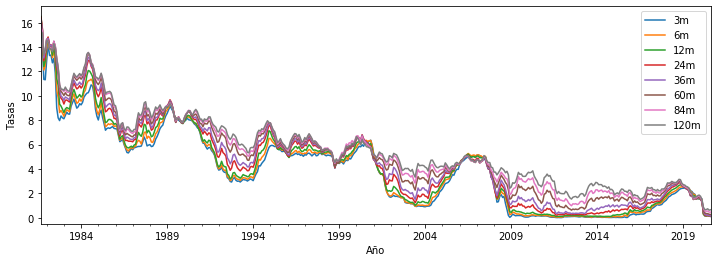

In [47]:
fig = df.plot(legend=True,figsize = (12,4))
fig.set_xlabel('Año')
fig.set_ylabel('Tasas')
fig.set_ylim(bottom=-0.5,top=None)
if save_figs==True:
    plt.savefig(f'{path_figs}/rates_db.eps',bbox_inches='tight',format='eps',dpi=1000)
plt.show()

Yield curve para un día en particular.

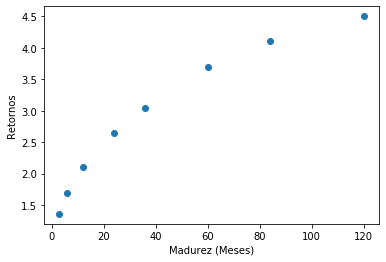

In [48]:
#yield curve arbitraria
plot_day = pd.Timestamp(2004,7,1)
plt.plot(np.array(maturity_months),np.array(df[df.index==plot_day]).reshape(len(maturity_months),1),'o')
plt.xlabel('Madurez (Meses)')
plt.ylabel('Retornos')
if save_figs==True:
    plt.savefig(f'{path_figs}/yield_curve_arbit.eps',bbox_inches='tight',format='eps',dpi=1000)
plt.show()

Nivel, pendiente y curvatura en los datos

The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.


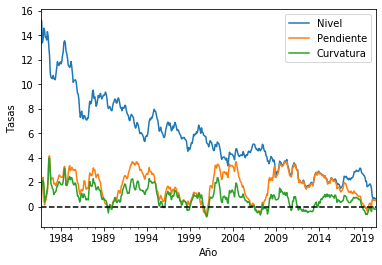

In [49]:
latent_data = pd.DataFrame()
if maturity_months[-1] == 360:
    latent_data['Level'] = df['360m']
    latent_data['Slope'] = df['360m']-df['3m']
    latent_data['Curvature'] = 2*df['84m']-df['3m']-df['360m']
    
elif maturity_months[-1] == 120:
    latent_data['Level'] = df['120m']
    latent_data['Slope'] = df['120m']-df['3m']
    latent_data['Curvature'] = 2*df['60m']-df['3m']-df['120m']
    
    
latent_data.set_index(df.index,inplace=True)
ax = latent_data.plot()
ax.legend(['Nivel','Pendiente','Curvatura'])
ax.set_xlabel('Año')
ax.set_ylabel('Tasas')
plt.axhline(0,linestyle='--',color='black')
if save_figs==True:
    plt.savefig(f'{path_figs}/latent_factors_ns.eps',bbox_inches='tight',format='eps',dpi=1000)
plt.show()

## Estimación
## Step 1: dado un $\lambda$, OLS cross section. Generamos time series de los betas.

Para cada mes, se corre una regresión lineal con el vector de yields como variable dependiente y los loading factors como vector de X's.

### Nelson Siegel Model

In [50]:
lambda_DL = 0.0609

#factor loadings
load_1 = np.repeat(1,df.shape[1])
load_2 = np.array([((1-math.exp(-lambda_DL*tau))/(lambda_DL*tau)) for tau in maturity_months])
load_3 = np.array([((1-math.exp(-lambda_DL*tau))/(lambda_DL*tau)) - math.exp(-lambda_DL*tau)  for tau in maturity_months])
loads = pd.DataFrame([load_1,load_2,load_3],index=['load_1','load_2','load_3']).transpose()

#regresiones
betas_ols = pd.DataFrame()
betas_ols['Date'] = df.index
betas_ols.set_index('Date',inplace=True)
betas_ols['beta_1'] = 0.
betas_ols['beta_2'] = 0.
betas_ols['beta_3'] = 0.

for date in df.index:
    rates = np.array(df[df.index==date]).reshape(len(maturity_months),1)
    model = sm.OLS(rates,loads)
    results = model.fit()
    betas_ols[betas_ols.index==date] = np.array(results.params).reshape(1,betas_ols.shape[1]) 

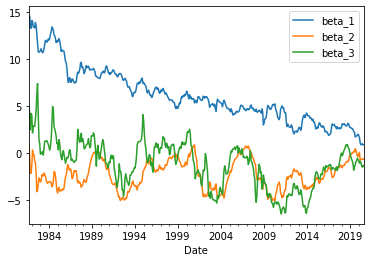

In [52]:
betas_ols.plot(legend=True)
plt.show()

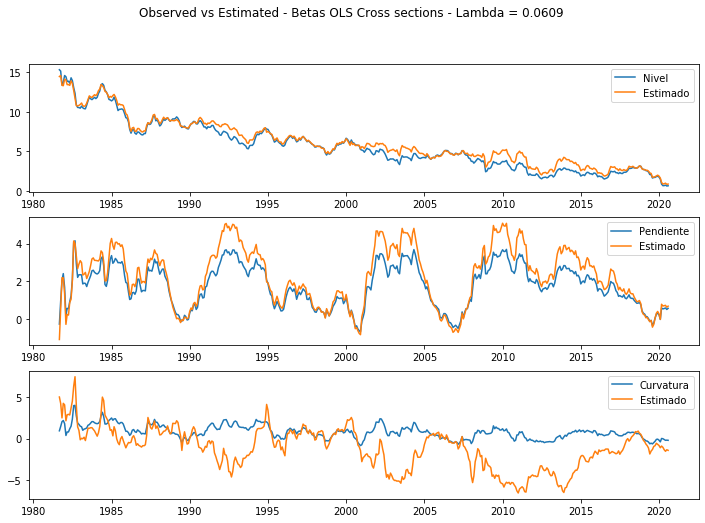

In [53]:
fig, axs = plt.subplots(3,figsize=(12,8))
fig.suptitle(f'Observed vs Estimated - Betas OLS Cross sections - Lambda = {lambda_DL} ')
axs[0].plot(df.index, latent_data['Level'])
axs[0].plot(df.index,betas_ols['beta_1'])
axs[1].plot(df.index,latent_data['Slope'])
axs[1].plot(df.index,-betas_ols['beta_2'])
axs[2].plot(df.index,latent_data['Curvature'])
axs[2].plot(df.index,betas_ols['beta_3'])
axs[0].legend(['Nivel','Estimado'])
axs[1].legend(['Pendiente','Estimado'])
axs[2].legend(['Curvatura','Estimado'])
plt.show()

### Estimación alternativa: Usamos curve_fit para estimar los betas y el $\lambda_{t}$ en cada mes.

Bajo esta forma alternativa de estimación, el valor de $\lambda_{t}$ no se fija de antemano, sinó que es un parámetro adicional a estiamar que cambia con el tiempo. Si bien a priori este método aparenta más flexible, tambien implica una complejidad mayor ya que se convierte en un modelo no lineal. Los resultados son altamente sensibles a los valores inicales y los bounds para los parámetros estimados. Cuando se consideran madureces menores a 10 años, el fit muestra ciertos problemas numéricos en algunas observaciones. Por lo tanto, se prefiere la especifición previamente mencionada.

In [54]:
betas_curvefit = pd.DataFrame()
betas_curvefit['Date'] = df.index
betas_curvefit.set_index('Date',inplace=True)
betas_curvefit['beta_1'] = 0.
betas_curvefit['beta_2'] = 0.
betas_curvefit['beta_3'] = 0.
betas_curvefit['lambda'] = 0.

init_values = [latent_data['Level'].median(),latent_data['Slope'].median(),latent_data['Curvature'].median(),lambda_DL]
bounds = ([0,-5,-5,0.02],[(latent_data['Level'].max())*2,(latent_data['Slope'].max())*2,5,0.15])


for date in df.index:
    rates = np.array(df[df.index==date]).reshape(len(maturity_months),1)
    TTM = np.array(maturity_months)
    popt, pcov = curve_fit(ns_formula, TTM.ravel(), rates.ravel(),p0 =init_values,bounds = bounds, maxfev=5000)
    betas_curvefit[betas_curvefit.index==date] = np.array(popt).reshape(1,4)
    

The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.


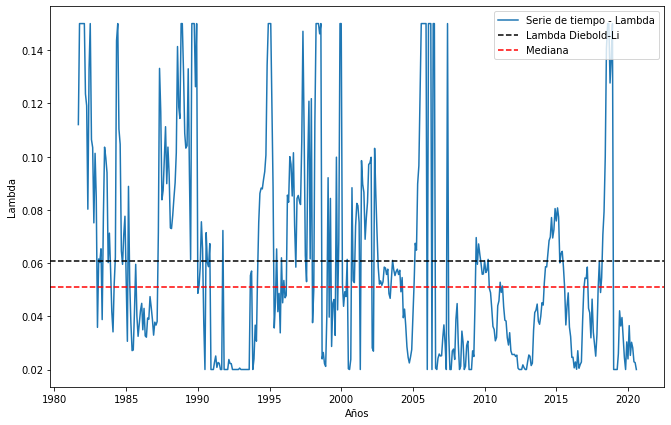

In [81]:
#lambdas curve fiting vs constante
plt.figure(figsize=(11,7))
plt.plot(betas_curvefit.index,betas_curvefit['lambda'],label='Serie de tiempo - Lambda')
plt.xlabel('Años')
plt.ylabel('Lambda')
plt.axhline(lambda_DL,linestyle='--',color = 'black',label = 'Lambda Diebold-Li')
plt.axhline(betas_curvefit['lambda'].median(),linestyle='--',color = 'red',label='Mediana')
plt.legend()
if save_figs==True:
    plt.savefig(f'{path_figs}/lambda_evol.eps',bbox_inches='tight',format='eps',dpi=1000)
plt.show()

The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript back

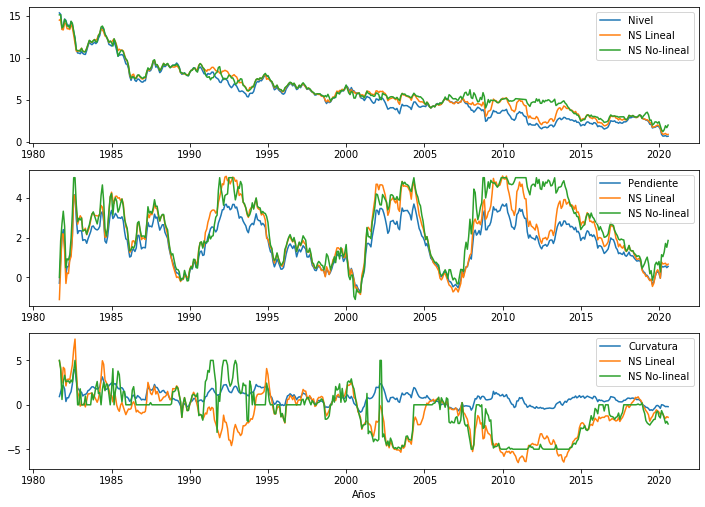

In [57]:
#Comparando actuals, lineal y curve_fit(non linear)
fig, axs = plt.subplots(3,figsize=(12,8.5))
axs[0].plot(df.index, latent_data['Level'])
axs[0].plot(df.index,betas_ols['beta_1'])
axs[0].plot(df.index,betas_curvefit['beta_1'])

axs[1].plot(df.index,latent_data['Slope'])
axs[1].plot(df.index,-betas_ols['beta_2'])
axs[1].plot(df.index,-betas_curvefit['beta_2'])

axs[2].plot(df.index,latent_data['Curvature'])
axs[2].plot(df.index,betas_ols['beta_3'])
axs[2].plot(df.index,betas_curvefit['beta_3'])
axs[2].set_xlabel('Años')

axs[0].legend(['Nivel','NS Lineal','NS No-lineal'])
axs[1].legend(['Pendiente','NS Lineal','NS No-lineal'])
axs[2].legend(['Curvatura','NS Lineal','NS No-lineal'])

if save_figs==True:
    plt.savefig(f'{path_figs}/lambda_resultados.eps',bbox_inches='tight',format='eps',dpi=1000)
plt.show()

## Litterman and Scheinkman (1991) Model (Dos factores)

Diebold, Piazzesi y Rudebush (2005) sugieren que un modelo de solo dos factores puede ser util para forecastear la term structure, pero dificilmente logre aproximar la yield curve en cada momento del tiempo de manera efectiva debido a su extrema simplicidad. A pesar de esto, ayuda el hecho de que la cantidad de parámetros a estimar es relativamente pequeña.
Para este modelo, se usa el mismo valor de $\lambda$ que el de Nelson Siegel tradicional.

In [58]:
loads_2f = loads[['load_1','load_2']]
#regresiones
betas_ols_2f = pd.DataFrame()
betas_ols_2f['Date'] = df.index
betas_ols_2f.set_index('Date',inplace=True)
betas_ols_2f['beta_1'] = 0.
betas_ols_2f['beta_2'] = 0.

for date in df.index:
    rates = np.array(df[df.index==date]).reshape(len(maturity_months),1)
    model = sm.OLS(rates,loads_2f)
    results = model.fit()
    betas_ols_2f[betas_ols_2f.index==date] = np.array(results.params).reshape(1,betas_ols_2f.shape[1])    

## Bjork and Christensen (1999) four-factor model

Extensión más simple del modelo Nelson Siegel. Se agrea un cuarto factor pero se mantiene el $\lambda$ como único time-decay factor. Este mdelo no se presenta en el trabajo.

In [59]:
loads_4f = loads.copy()
loads_4f['load_4'] = np.array([((1-math.exp(-2*lambda_DL*tau))/(2*lambda_DL*tau)) for tau in maturity_months])

#regresiones
betas_ols_4f = pd.DataFrame()
betas_ols_4f['Date'] = df.index
betas_ols_4f.set_index('Date',inplace=True)
betas_ols_4f['beta_1'] = 0.
betas_ols_4f['beta_2'] = 0.
betas_ols_4f['beta_3'] = 0.
betas_ols_4f['beta_4'] = 0

for date in df.index:
    rates = np.array(df[df.index==date]).reshape(len(maturity_months),1)
    model = sm.OLS(rates,loads_4f)
    results = model.fit()
    betas_ols_4f[betas_ols_4f.index==date] = np.array(results.params).reshape(1,betas_ols_4f.shape[1]) 

## Svensonn (1994) four factor model

Extensión algo más compleaja del modelo de Nelson Siegel. al igual que el modelo de Bjork y Christensen, posee 4 factores peero con dos time-decay parameteres que a priori cambian en el tiempo. Para simplificar la estimación, fijamos $\lambda_1 = 0.0609$ y $\lambda_2=0.10277$

In [60]:
lambda_SV = 0.10277
loads_4fs = loads.copy()
loads_4fs['load_4'] = np.array([((1-math.exp(-lambda_SV*tau))/(lambda_SV*tau)) - math.exp(-lambda_SV*tau)  for tau in maturity_months])


#regresiones
betas_ols_4fs = pd.DataFrame()
betas_ols_4fs['Date'] = df.index
betas_ols_4fs.set_index('Date',inplace=True)
betas_ols_4fs['beta_1'] = 0.
betas_ols_4fs['beta_2'] = 0.
betas_ols_4fs['beta_3'] = 0.
betas_ols_4fs['beta_4'] = 0

for date in df.index:
    rates = np.array(df[df.index==date]).reshape(len(maturity_months),1)
    model = sm.OLS(rates,loads_4fs)
    results = model.fit()
    betas_ols_4fs[betas_ols_4fs.index==date] = np.array(results.params).reshape(1,betas_ols_4fs.shape[1])    

## Step 2: Estimamos un VAR sobre las series temporales de los betas estimados en el step anterior. 


In [61]:
model_var_ns = VAR(betas_ols)
results_var_ns = model_var_ns.fit(1)
results_var_ns.summary()

  Summary of Regression Results   
Model:                         VAR
Method:                        OLS
Date:           Sun, 06, Dec, 2020
Time:                     14:01:56
--------------------------------------------------------------------
No. of Equations:         3.00000    BIC:                   -5.89593
Nobs:                     467.000    HQIC:                  -5.96055
Log likelihood:          -574.354    FPE:                 0.00247262
AIC:                     -6.00248    Det(Omega_mle):      0.00241016
--------------------------------------------------------------------
Results for equation beta_1
               coefficient       std. error           t-stat            prob
----------------------------------------------------------------------------
const             0.015560         0.038726            0.402           0.688
L1.beta_1         0.996436         0.006256          159.286           0.000
L1.beta_2         0.015560         0.011317            1.375           0.16

In [62]:
#Ejemplo de parámetros estimados en el VAR
results_var_ns.params

,beta_1,beta_2,beta_3
const,0.015560,0.121827,-0.157694
L1.beta_1,0.996436,-0.041059,0.020695
L1.beta_2,0.015560,0.912437,0.022922
L1.beta_3,-0.010502,0.061332,0.940455


## In-Sample Fit

Se compara la performance in sample de los tres modelos sobre la yield curve de cada mes. Se computa el RMSE sobre las maturities para las que hay observaciones.

In [64]:
# Data frame para almacenar RMSE por maturity y modelo
modelos = 4
modelos_lista = ['Litterman Scheinkman','Nelson Siegel','Bjork and Christensen','Svennson']

if maturity_months[-1] == 360:
    rmse_models = pd.DataFrame(np.zeros((len(maturity_months),modelos)),index = ['3m','6m','12m','24m','36m','60m','84m','120m','240m','360m'])
elif maturity_months[-1] == 120:
    rmse_models = pd.DataFrame(np.zeros((len(maturity_months),modelos)),index = ['3m','6m','12m','24m','36m','60m','84m','120m'])



for maturity in maturity_months:
    rmse_maturity = pd.DataFrame(np.zeros((len(df.index),modelos+1)))
    rmse_maturity.set_index(df.index,inplace=True)
    rmse_maturity[0] = df[str(maturity)+'m']
    
    for date in rmse_maturity.index:
        
        #retrive betas from ols reg - Nelson Siegel model
        beta1_ols = betas_ols.beta_1[betas_ols.index==date]
        beta2_ols = betas_ols.beta_2[betas_ols.index==date]
        beta3_ols = betas_ols.beta_3[betas_ols.index==date]

        #retrive betas from ols reg - 2 factor model
        beta1_ols_2f= betas_ols_2f.beta_1[betas_ols_2f.index==date]
        beta2_ols_2f = betas_ols_2f.beta_2[betas_ols_2f.index==date]
        
        #four factor
        beta1_ols_4f= betas_ols_4f.beta_1[betas_ols_4f.index==date]
        beta2_ols_4f = betas_ols_4f.beta_2[betas_ols_4f.index==date]
        beta3_ols_4f = betas_ols_4f.beta_3[betas_ols_4f.index==date]
        beta4_ols_4f = betas_ols_4f.beta_4[betas_ols_4f.index==date]

        #Svensonn model
        beta1_ols_4fs= betas_ols_4fs.beta_1[betas_ols_4fs.index==date]
        beta2_ols_4fs = betas_ols_4fs.beta_2[betas_ols_4fs.index==date]
        beta3_ols_4fs = betas_ols_4fs.beta_3[betas_ols_4fs.index==date]
        beta4_ols_4fs = betas_ols_4fs.beta_4[betas_ols_4fs.index==date]
        
        rmse_maturity[1].loc[date] = float(twofactors_formula(maturity,beta1_ols_2f,beta2_ols_2f,lambda_DL))
        rmse_maturity[2].loc[date] = float(ns_formula(maturity,beta1_ols,beta2_ols,beta3_ols,lambda_DL))
        rmse_maturity[3].loc[date] = float(fourfactors_formula(maturity,beta1_ols_4f,beta2_ols_4f,beta3_ols_4f,beta4_ols_4f,lambda_DL))
        rmse_maturity[4].loc[date] = float(sv_formula(maturity,beta1_ols_4fs,beta2_ols_4fs,beta3_ols_4fs,beta4_ols_4fs,lambda_DL,lambda_SV))

    rmse_models[0].loc[str(maturity)+'m'] = np.sqrt(mean_squared_error(rmse_maturity[0],rmse_maturity[1]))
    rmse_models[1].loc[str(maturity)+'m'] = np.sqrt(mean_squared_error(rmse_maturity[0],rmse_maturity[2]))
    rmse_models[2].loc[str(maturity)+'m'] = np.sqrt(mean_squared_error(rmse_maturity[0],rmse_maturity[3]))
    rmse_models[3].loc[str(maturity)+'m'] = np.sqrt(mean_squared_error(rmse_maturity[0],rmse_maturity[4]))
    
    
rmse_models.columns = modelos_lista    


In [65]:
#tabla para documento
print(rmse_models.drop("Bjork and Christensen",axis=1).round(decimals=4).to_latex(bold_rows=True))

\begin{tabular}{lrrr}
\toprule
{} &  Litterman Scheinkman &  Nelson Siegel &  Svennson \\
\midrule
\textbf{3m  } &                0.2353 &         0.0815 &    0.0290 \\
\textbf{6m  } &                0.0990 &         0.0679 &    0.0522 \\
\textbf{12m } &                0.1288 &         0.0772 &    0.0378 \\
\textbf{24m } &                0.2438 &         0.0432 &    0.0404 \\
\textbf{36m } &                0.2455 &         0.0477 &    0.0246 \\
\textbf{60m } &                0.1009 &         0.0698 &    0.0369 \\
\textbf{84m } &                0.1044 &         0.0410 &    0.0394 \\
\textbf{120m} &                0.2788 &         0.0624 &    0.0265 \\
\bottomrule
\end{tabular}



In [67]:
rmse_models.mean()

Litterman Scheinkman     0.179547
Nelson Siegel            0.061337
Bjork and Christensen    0.035893
Svennson                 0.035860
dtype: float64

## Out - Sample Testing

Si bien es importante onsiderar que tan bien ajustan los modelos a la estructura de retornos dentro de la muestra, no hay que perder de vista la capacidad predictiva de ellos ante nuevas observaciones.
Se considera la muestra 1981-2018 para entrenar los modelos, tal y como se hizo más arriba. Para cada uno de ellos, se generan series de tiempo mensuales de los $\beta$'s y se estima un VAR(1). Luego, los one-month ahead forecast se construyen de la siguiente manera
- Se genera un vector de $\beta$'s para la observación futura, utilizando toda la info de observaciones previas con los coeficientes del VAR estimados in-sample
- Se crea el vector de yields predecidos por cada modelo con los $\beta$'s del punto anterior

In [68]:
# generamos series de tiempo de los betas para los tres modelos con muestra 1981-2018 (2019-2020 para test)
oos_cut = pd.Timestamp(2011,1,1)
df_oos = df[df.index>oos_cut].copy() # data frame con la parte out sample (sirve mas adelante)

#ns
betas_ols_insample = betas_ols[betas_ols.index<oos_cut]
#2 factors
betas_ols_2f_insample = betas_ols_2f[betas_ols_2f.index<oos_cut]
#svenson
betas_ols_4fs_insample = betas_ols_4fs[betas_ols_4fs.index<oos_cut]

# estimamos un var con la serie de tiempo de arriba.

#ns
var_insample_ns = VAR(betas_ols_insample)
results_var_insample_ns = var_insample_ns.fit(1)
#2f
var_insample_2f = VAR(betas_ols_2f_insample)
results_var_insample_2f = var_insample_2f.fit(1)
#svenson
var_insample_4fs = VAR(betas_ols_4fs_insample)
results_var_insample_4fs = var_insample_4fs.fit(1)


# Construcción del one-step ahead forecast

#oos_ns es un data frame que contiene los predicted yield con el one-step ahead forecast.

# ns
oos_ns = pd.DataFrame(np.zeros((len(df[df.index>=oos_cut].index),len(maturity_months))))
    
for i,date in enumerate(df[df.index>=oos_cut].index):
    #Para cada día, se contruye vector de betas usando los del dia anterior
    betas = results_var_insample_ns.forecast(betas_ols.shift(1).values[betas_ols.index==date],steps=1)[0]
    for j,maturity in enumerate(maturity_months):
        oos_ns.loc[i,j] = float(ns_formula(maturity,betas[0],betas[1],betas[2],lambda_DL))
        
        
oos_ns.set_index(df[df.index>=oos_cut].index,inplace=True)
oos_ns.columns=[(str(i) + 'm') for i in maturity_months]

# 2f
oos_2f = pd.DataFrame(np.zeros((len(df[df.index>=oos_cut].index),len(maturity_months))))
    
for i,date in enumerate(df[df.index>=oos_cut].index):
    #Para cada día, se contruye vector de betas usando los del dia anterior
    betas = results_var_insample_2f.forecast(betas_ols_2f.shift(1).values[betas_ols_2f.index==date],steps=1)[0]
    for j,maturity in enumerate(maturity_months):
        oos_2f.loc[i,j] = float(twofactors_formula(maturity,betas[0],betas[1],lambda_DL))
        
        
oos_2f.set_index(df[df.index>=oos_cut].index,inplace=True)
oos_2f.columns=[(str(i) + 'm') for i in maturity_months]


# sv
oos_4fs = pd.DataFrame(np.zeros((len(df[df.index>=oos_cut].index),len(maturity_months))))
    
for i,date in enumerate(df[df.index>=oos_cut].index):
    #Para cada día, se contruye vector de betas usando los del dia anterior
    betas = results_var_insample_4fs.forecast(betas_ols_4fs.shift(1).values[betas_ols_4fs.index==date],steps=1)[0]
    for j,maturity in enumerate(maturity_months):
        oos_4fs.loc[i,j] = float(sv_formula(maturity,betas[0],betas[1],betas[2],betas[3],lambda_DL,lambda_SV))
        
        
oos_4fs.set_index(df[df.index>=oos_cut].index,inplace=True)
oos_4fs.columns=[(str(i) + 'm') for i in maturity_months]

Para computar el RMSE de los one-step ahead forecasts, contruimos un dataframe para cada maturity con los predicted yields de los modelos a comparar

In [69]:
#data frame para almacenar RMSE por maturity y por modelo (out sample)

if maturity_months[-1] == 360:
    rmse_models_oos = pd.DataFrame(np.zeros((len(maturity_months),3)),index = ['3m','6m','12m','24m','36m','60m','84m','120m','240m','360m'])
elif maturity_months[-1] == 120:
    rmse_models_oos = pd.DataFrame(np.zeros((len(maturity_months),3)),index = ['3m','6m','12m','24m','36m','60m','84m','120m'])

    
for maturity in maturity_months: 
    rmse_maturity_oos = pd.DataFrame(np.zeros((len(df_oos.index),4)))
    rmse_maturity_oos.set_index(df_oos.index,inplace=True)
    rmse_maturity_oos[0] = df_oos[str(maturity)+'m']
    rmse_maturity_oos[1] = oos_2f[str(maturity)+'m']
    rmse_maturity_oos[2] = oos_ns[str(maturity)+'m']
    rmse_maturity_oos[3] = oos_4fs[str(maturity)+'m']
    
    rmse_models_oos[0].loc[str(maturity)+'m'] = np.sqrt(mean_squared_error(rmse_maturity_oos[0],rmse_maturity_oos[1]))
    rmse_models_oos[1].loc[str(maturity)+'m'] = np.sqrt(mean_squared_error(rmse_maturity_oos[0],rmse_maturity_oos[2]))
    rmse_models_oos[2].loc[str(maturity)+'m'] = np.sqrt(mean_squared_error(rmse_maturity_oos[0],rmse_maturity_oos[3]))
    
rmse_models_oos.columns = ['Dos factores','Nelson Siegel','Svennson']

The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.


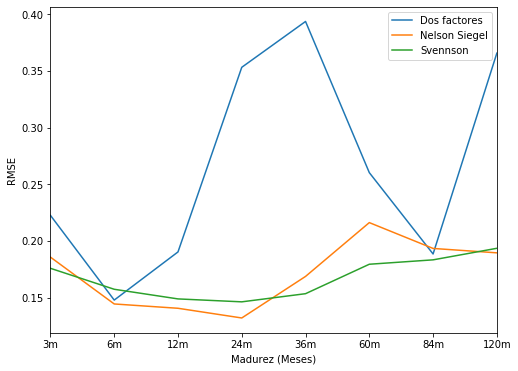

In [70]:
rmse_models_oos.plot(figsize=(8,6))
plt.ylabel('RMSE')
plt.xlabel('Madurez (Meses)')
if save_figs==True:
    plt.savefig(f'{path_figs}/rmse_oos_2011.eps',bbox_inches='tight',format='eps',dpi=1000)
plt.show()

## Gráficos Varios

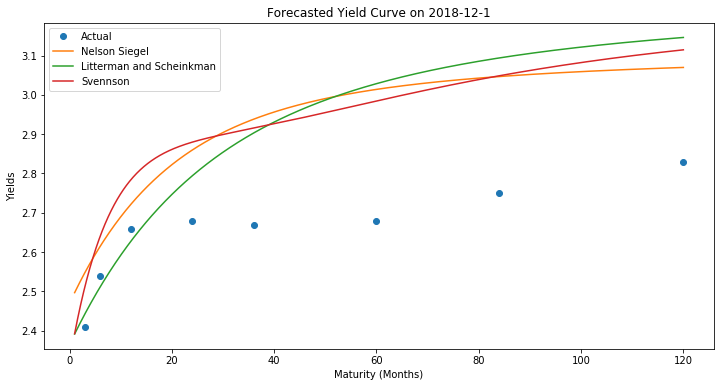

In [71]:
oos_plot_day = pd.Timestamp(2018,12,1) # revisart esto. Deberia solo funcionar para 2019/2020
#Esta bien. hay que ponerle un if day < cut, error.

yield_curve_plot_day_oos(oos_plot_day,maturity_months[-1])

In [72]:
#yield curve promedio actual vs predicted por modelos

ttms = np.linspace(1, maturity_months[-1], num=500, endpoint=True)
yields_2f = pd.DataFrame(np.zeros((len(df.index),len(ttms))))
yields_2f.set_index(df.index,inplace=True)
yields_ns = yields_2f.copy()
yields_sv = yields_2f.copy()
yields_4f = yields_2f.copy()

for date in df.index:

    #retrive betas from ols reg - Nelson Siegel model
    beta1_ols = betas_ols.beta_1[betas_ols.index==date]
    beta2_ols = betas_ols.beta_2[betas_ols.index==date]
    beta3_ols = betas_ols.beta_3[betas_ols.index==date]
    
    #retrive betas from ols reg - 2 factor model
    beta1_ols_2f= betas_ols_2f.beta_1[betas_ols_2f.index==date]
    beta2_ols_2f = betas_ols_2f.beta_2[betas_ols_2f.index==date]
    
    #four factor
    beta1_ols_4f= betas_ols_4f.beta_1[betas_ols_4f.index==date]
    beta2_ols_4f = betas_ols_4f.beta_2[betas_ols_4f.index==date]
    beta3_ols_4f = betas_ols_4f.beta_3[betas_ols_4f.index==date]
    beta4_ols_4f = betas_ols_4f.beta_4[betas_ols_4f.index==date]
    
    #Svensonn model
    beta1_ols_4fs= betas_ols_4fs.beta_1[betas_ols_4fs.index==date]
    beta2_ols_4fs = betas_ols_4fs.beta_2[betas_ols_4fs.index==date]
    beta3_ols_4fs = betas_ols_4fs.beta_3[betas_ols_4fs.index==date]
    beta4_ols_4fs = betas_ols_4fs.beta_4[betas_ols_4fs.index==date]
    
    yields_2f[yields_2f.index==date]= np.array([twofactors_formula(t,beta1_ols_2f,beta2_ols_2f,lambda_DL) for t in ttms]).reshape(1,len(ttms))
    yields_ns[yields_ns.index==date]= np.array([ns_formula(t,beta1_ols,beta2_ols,beta3_ols,lambda_DL) for t in ttms]).reshape(1,len(ttms))
    yields_4f[yields_4f.index==date] = np.array([fourfactors_formula(t,beta1_ols_4f,beta2_ols_4f,beta3_ols_4f,beta4_ols_4f,lambda_DL) for t in ttms]).reshape(1,len(ttms))
    yields_sv[yields_sv.index==date]= np.array([sv_formula(t,beta1_ols_4fs,beta2_ols_4fs,beta3_ols_4fs,beta4_ols_4fs,lambda_DL,lambda_SV) for t in ttms]).reshape(1,len(ttms))

The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.


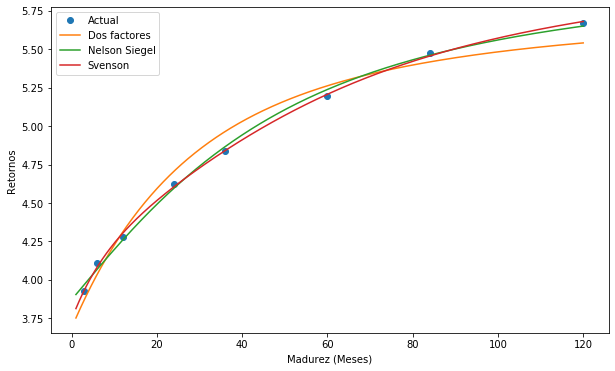

In [73]:
#average yield curve
plt.figure(figsize=(10,6))
plt.plot(maturity_months,df.mean(),'o',label='Actual')
plt.plot(ttms,yields_2f.mean(),label='Dos factores')
plt.plot(ttms,yields_ns.mean(),label='Nelson Siegel')
#plt.plot(ttms,yields_4f.mean(),label='Bjork Christensen')
plt.plot(ttms,yields_sv.mean(),label='Svenson')
plt.legend()
plt.xlabel('Madurez (Meses)')
plt.ylabel('Retornos')
if save_figs==True:
    plt.savefig(f'{path_figs}/yieldcurve_promedio.eps',bbox_inches='tight',format='eps',dpi=1000)
plt.show()

The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.


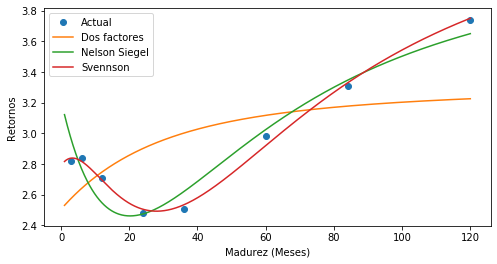

In [74]:
#gráfico yield curve un dia en particular con predicted por los modelos
plot_day = pd.Timestamp(2008,1,1)
yield_curve_plot_day(plot_day,maturity_months[-1],"yieldcurve_2008_1_1")

The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.


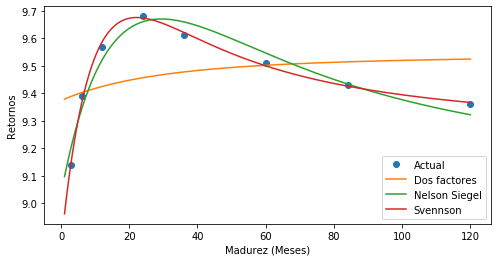

In [75]:
plot_day = pd.Timestamp(1989,3,1)
yield_curve_plot_day(plot_day,maturity_months[-1],"yieldcurve_1989_3_1")

The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.


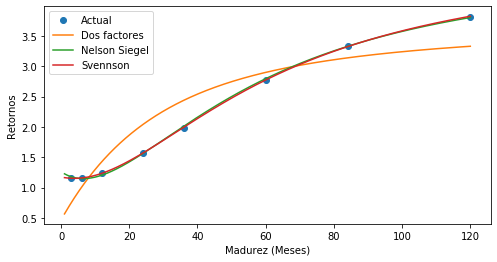

In [76]:
plot_day = pd.Timestamp(2003,3,1)
yield_curve_plot_day(plot_day,maturity_months[-1],"yieldcurve_2003_3_1")

The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.


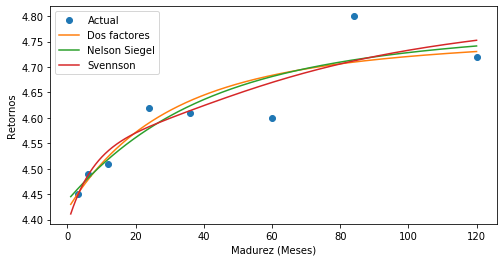

In [77]:
plot_day = pd.Timestamp(1999,1,1)
yield_curve_plot_day(plot_day,maturity_months[-1],"yieldcurve_1999_1_1")

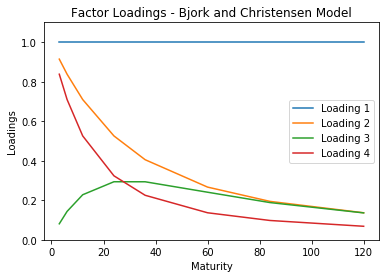

In [78]:
plt.figure(figsize = (6,4))
plt.plot(maturity_months,loads_4f['load_1'],label='Loading 1')
plt.plot(maturity_months,loads_4f['load_2'],label='Loading 2')
plt.plot(maturity_months,loads_4f['load_3'],label='Loading 3')
plt.plot(maturity_months,loads_4f['load_4'],label='Loading 4')
plt.title('Factor Loadings - Bjork and Christensen Model')
plt.xlabel('Maturity')
plt.ylabel('Loadings')
plt.ylim(0,1.1)
plt.legend()
plt.show()

The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.


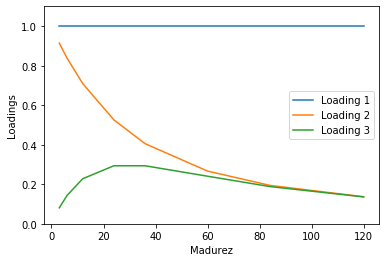

In [79]:
#Loadings factors - Nelson Siegel
plt.figure(figsize = (6,4))
plt.plot(maturity_months,load_1,label='Loading 1')
plt.plot(maturity_months,load_2,label='Loading 2')
plt.plot(maturity_months,load_3,label='Loading 3')
plt.xlabel('Madurez')
plt.ylabel('Loadings')
plt.ylim(0,1.1)
plt.legend()
if save_figs==True:
    plt.savefig(f'{path_figs}/loadings_ns.eps',bbox_inches='tight',format='eps',dpi=1000)
plt.show()

The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.


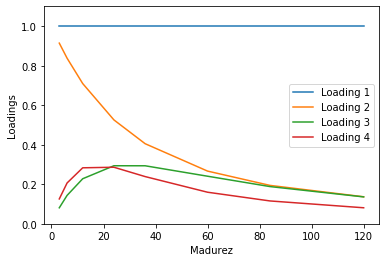

In [80]:
#loadings Svensonn
plt.figure(figsize = (6,4))
plt.plot(maturity_months,loads_4fs['load_1'],label='Loading 1')
plt.plot(maturity_months,loads_4fs['load_2'],label='Loading 2')
plt.plot(maturity_months,loads_4fs['load_3'],label='Loading 3')
plt.plot(maturity_months,loads_4fs['load_4'],label='Loading 4')
plt.xlabel('Madurez')
plt.ylabel('Loadings')
plt.ylim(0,1.1)
plt.legend()
if save_figs==True:
    plt.savefig(f'{path_figs}/loadings_sv.eps',bbox_inches='tight',format='eps',dpi=1000)
plt.show()